In [4]:
# General
import numpy as np
import matplotlib.pyplot as plt

# For handling structures and visualizing structures
from ase import Atoms
from ase.build import graphene_nanoribbon
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io import read, write

# For MD
from ase.calculators.tersoff import Tersoff
from ase.constraints import FixAtoms
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ase.neighborlist import neighbor_list

# Function for drawing atoms with atom indices and color depending MD constraint
def draw_atoms(atoms, radius=200, drawfixed=True):
    fig, ax = plt.subplots()

    # For drawing constraints
    if len(atoms.constraints) > 0:
        constraints = atoms.constraints[0].index
    else:
        constraints = []

    for ai, atom in enumerate(atoms):
        color = "k"
        if drawfixed and ai in constraints:
            color = "tab:red"
        ax.scatter(atom.position[2], atom.position[0], color=color, alpha=0.5, s=radius)
        ax.annotate(ai, (atom.position[2], atom.position[0]), ha="center", va="center", color="white")
    ax.set_xlim([0, atoms.cell[2,2]])
    ax.set_ylim([0, atoms.cell[0,0]])
    ax.set_xlabel("z, Å")
    ax.set_ylabel("x, Å")
    ax.axis("equal")
    return ax

# Function for loading and plotting temperature along MD trajectory
def plot_mdlog(fname="md.log"):
    log = np.loadtxt(fname, skiprows=1)
    fig, ax = plt.subplots()
    ax.plot(log[:,0], log[:, 4], color="k", alpha=0.5)
    ax.set_xlabel("Time, ps")
    ax.set_ylabel("Temperature, K")
    return ax

# Function for sorting if needed
def sort_atoms(atoms):
    pos = atoms.get_positions()
    sorted_indices = np.lexsort((pos[:, 0], pos[:, 1], pos[:, 2]))
    return atoms[sorted_indices]

## Make Hamiltonians

In [7]:
# Here calculate and plot the band structure for unit cell

def hamdd(xyz):
    #### Distance-dependent tight binding hamiltonian for a set of atomic coordinates in units of Vpppi
    cut = bond + 0.3 # only look up to this distance
    N = len(xyz)
    hamdd = np.zeros([N,N])
    dist = np.linalg.norm(xyz[None, :, :] - xyz[:, None, :], axis=2)
    for i in np.arange(N):
        for j in np.arange(N):
            if (i != j) & (dist[i,j] < cut):
                hamdd[i,j] = Vpppi*(bond/dist[i,j])**2  # if using distance dependence!
    return hamdd

def hamhop(xyz1,xyz2):
    #### The hopping/hamiltonian between the set of atoms with coordinates xyz1 and xyz2 (n1 x n2 matrix)
    n1 = len(xyz1)
    n2 = len(xyz2)
    xyz = np.concatenate((xyz1,xyz2)) ## combine coordinates to total
    htmp = hamdd(xyz)
    return htmp[0:n1,n1:n1+n2]

def get_ham_k(atoms, k_scaled, hamhop, Rmax=1, hermitize=True):
    """
    H(k) = sum_R H(R) exp(i 2π k·R)
    """
    xyz = atoms.get_positions()
    cell = atoms.cell.array
    pbc  = atoms.get_pbc()
    n    = len(xyz)

    # Integer translations R (only periodic directions)
    ranges = [range(-Rmax, Rmax+1) if p else [0] for p in pbc]
    R = np.array(np.meshgrid(*ranges, indexing="ij")).reshape(3, -1).T  # (nR,3)

    # Cartesian translations
    T = R @ cell  # (nR,3)

    # Hopping matrices H(R)
    # HR = np.stack([hamhop(xyz, xyz + Ti) for Ti in T], axis=0)  # (nR,n,n)
    
    # Handle R=0 (self-interaction) separately to avoid division by zero in hamhop
    HR_list = []
    for Ti in T:
        if np.linalg.norm(Ti) < 1e-5:
            HR_list.append(hamdd(xyz))
        else:
            HR_list.append(hamhop(xyz, xyz + Ti))
            
    HR = np.stack(HR_list, axis=0)  # (nR,n,n)

    # Phase factors and contraction
    phases = np.exp(1j * 2*np.pi * (R @ k_scaled))              # (nR,)
    Hk = np.tensordot(phases, HR, axes=(0, 0))                  # (n,n)
    if hermitize:
        Hk = 0.5 * (Hk + Hk.conj().T)
    return Hk

In [8]:
def SplitHam(H, nL, nR):
    no = H.shape[0]
    nC = no - 2*nL - 2*nR
    nD = nL + nC + nR
    if nC < 1:
        print("Setup error: central region size =", nC)
        print("Use [L | L | C | R | R] setup")
        return
    
    # Boundaries
    b0 = 0
    b1 = nL
    b2 = 2*nL
    b3 = 2*nL + nC
    b4 = 2*nL + nC + nR
    b5 = no

    HL = H[b0:b1, b0:b1]    # Left lead onsite (L1)
    VL = H[b1:b2, b0:b1]    # L2 → L1 hopping

    VCL = H[b2:b3, b1:b2]   # C → L2
    VLC = VCL.T.conj()      # L2 → C

    HC = H[b2:b3, b2:b3]    # Central region
    VCR = H[b2:b3, b3:b4]   # C → R1
    VRC = VCR.T.conj()      # R1 → C

    VR = H[b3:b4, b4:b5]    # R1 → R2 hopping

    HR = H[b4:b5, b4:b5]    # Right lead onsite (R2)

    HD = H[b1:b4, b1:b4]    # Device block
    VLD = H[b1:b4, b0:b1]   # L1 → device
    VRD = H[b1:b4, b4:b5]   # device → R2

    # Return in left → right order
    return HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD

def plot_ham(nL, nR, Hbig):
    nC = Hbig.shape[0] - 2*nL - 2*nR
    b0 = 0
    b1 = nL
    b2 = 2*nL
    b3 = 2*nL + nC
    b4 = 2*nL + nC + nR
    b5 = Hbig.shape[0]

    plt.figure(figsize=(8,8))
    plt.spy(Hbig,extent=(0, Hbig.shape[0], Hbig.shape[0],0))
    # Draw block boundaries
    for b in [b1, b2, b3, b4]:
        plt.axhline(b, color='k', linewidth=1)
        plt.axvline(b, color='k', linewidth=1)

    # Add text labels
    plt.text((b0+b1)/2, (b0+b1)/2, "L1", ha='center', va='center', color='blue')

    plt.text((b1+b2)/2, (b1+b2)/2, "L2", ha='center', va='center', color='green')
    plt.text((b2+b3)/2, (b2+b3)/2, "C", ha='center', va='center', color='green')
    plt.text((b3+b4)/2, (b3+b4)/2, "R1", ha='center', va='center', color='green')
    plt.text((b4+b5)/2, (b4+b5)/2, "R2", ha='center', va='center', color='blue')

    plt.show()

def get_surface_greens_function(h_unit, v_unit, z, max_iter=100,tol=1e-10):
    h = np.array(h_unit, dtype=complex)
    v = np.array(v_unit, dtype=complex)
    v_dag = v.T.conj()
    dim = h.shape[0]
    I = np.eye(dim)
    
    eps_s, eps = h.copy(), h.copy()
    alpha, beta = v.copy(), v_dag.copy()
       
    for _ in range(max_iter):
        zI_eps = z * I - eps
        # Using solve for better numerical stability than direct inv
        g_alpha = np.linalg.solve(zI_eps, alpha)
        g_beta = np.linalg.solve(zI_eps, beta)
           
        alpha_next = alpha @ g_alpha
        beta_next = beta @ g_beta
        eps_next = eps + alpha @ g_beta + beta @ g_alpha
        eps_s_next = eps_s + alpha @ g_beta
           
        if np.linalg.norm(alpha_next, ord=np.inf) < tol:
            eps_s = eps_s_next
            break
        alpha, beta, eps, eps_s = alpha_next, beta_next, eps_next, eps_s_next

    g_s=np.linalg.inv(z * I - eps_s)
    g_b=np.linalg.inv(z * I - eps)
    sigma_s=eps_s-h.copy()
    sigma_b=eps-h.copy()

    return g_s,g_b,sigma_s,sigma_b

## Pristine structure

Number of atoms (and orbitals) in unit cell: 20


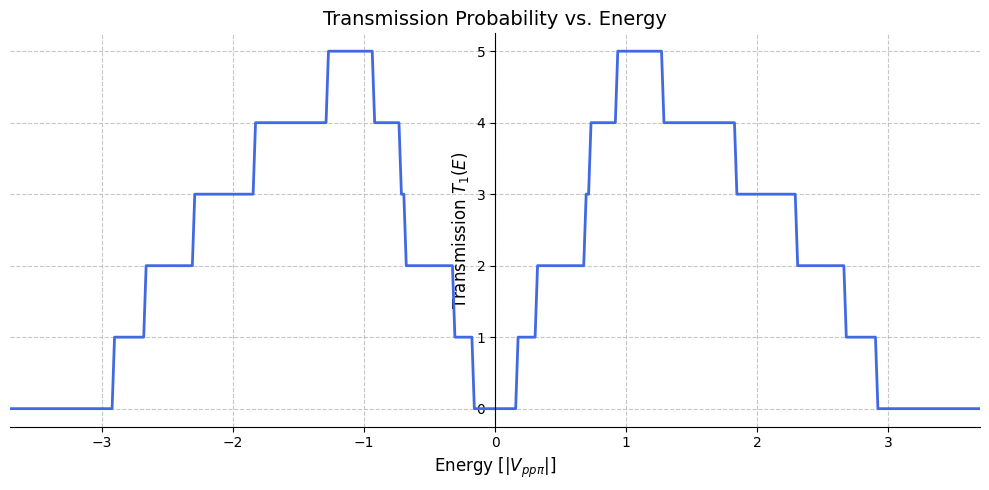

In [9]:
kind = "armchair"     # "armchair" or "zigzag"
n = 5                 # width parameter
length = 1            # periodic repetitions along z, i.e., transport direction here
vacuum = 15.0         # vacuum in non-periodic directions (Å)
bond = 1.43877067     # Optimized using C.tersoff potential discussed below
Vpppi = -2.7          # eV

ribbon = graphene_nanoribbon(n=n,
                             m=length,
                             type=kind,
                             C_C=bond,
                             vacuum=vacuum)
ribbon.pbc = True
ribbon = sort_atoms(ribbon)

structure = ribbon

Ntransport = 5 # number of repetitions in transport direction (z). To create simple [L|L|C|R|R] geometry.
pristine_structure = structure.repeat((1, 1, Ntransport))

natom_elec = len(structure)
print("Number of atoms (and orbitals) in unit cell:", natom_elec)

positions = pristine_structure.get_positions()
Hbig = hamdd(positions)

HL, VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD = SplitHam(Hbig, natom_elec, natom_elec)

dim = HC.shape[0]
I = np.eye(dim, dtype=complex)

energy = np.linspace(-10,10,400)    # energy range

transmission = np.zeros_like(energy)
for i, e in enumerate(energy):
    z = e + 1j*1e-8
    gl_s, gl_b, sigmal_s, sigmal_b = get_surface_greens_function(HL, VL, z)
    gr_s, gr_b, sigmar_s, sigmar_b = get_surface_greens_function(HR, VR, z)

    # left and right lead, eq 134
    sigma_L = VLC.T.conj() @ gl_s @ VLC
    sigma_R = VRC.T.conj() @ gr_s @ VRC

    # gammas, eq 136
    gamma_L = 1j * (sigma_L - sigma_L.T.conj())
    gamma_R = 1j * (sigma_R - sigma_R.T.conj())

    g_C = np.linalg.inv(z * I - HC - sigma_L - sigma_R)
    t_matrix = gamma_R @ g_C @ gamma_L @ g_C.T.conj()

    transmission[i] = np.trace(t_matrix).real

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Plot 1: Transmission 1
ax1.plot(energy / 2.7, transmission, color='royalblue', linewidth=2)
ax1.set_ylabel(r'Transmission $T_1(E)$', fontsize=12)
ax1.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
ax1.set_title('Transmission Probability vs. Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

# Move left y-axis spine to x = 0
ax1.spines['left'].set_position(('data', 0))
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

plt.xlim(energy.min()/2.7, energy.max()/2.7)
plt.tight_layout()
plt.show()

-153.37831020173678 eV
[[ 2.94629247e+00  0.00000000e+00 -5.10372143e+00]
 [ 0.00000000e+00  0.00000000e+00  5.99616235e-15]
 [ 0.00000000e+00  0.00000000e+00  5.99616235e-15]
 [ 0.00000000e+00  0.00000000e+00  5.99616235e-15]
 [ 2.94680618e+00  0.00000000e+00 -2.63708103e+00]
 [-2.94680618e+00  0.00000000e+00  2.63708103e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.99611702e-15]
 [ 0.00000000e+00  0.00000000e+00 -5.99611702e-15]
 [ 0.00000000e+00  0.00000000e+00 -5.99611702e-15]
 [-2.94629247e+00  0.00000000e+00  5.10372143e+00]
 [-2.94680618e+00  0.00000000e+00 -2.63708103e+00]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [-2.94629247e+00  0.00000000e+00 -5.10372143e+00]
 [ 2.94629247e+00  0.00000000e+00  5.10372143e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.76996262e-15]
 [ 0.00000000e+00  0.00000000e+00 -9.76996262e-15]
 [ 0.00000000e+00  0.00000000e+00 -9.76996262e-15]
 [ 2.946

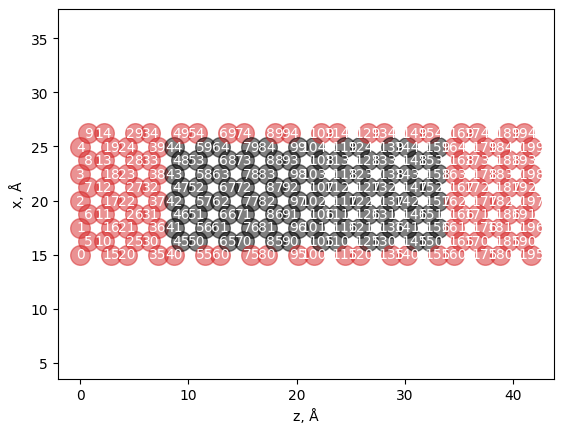

In [13]:
# Load parameter file
calc = Tersoff.from_lammps("C.tersoff")

# Set up calculator
structure.calc = calc # Attach Tersoff calculator based on parameters in C.tersoff

# Now based on this interatomic potential, we can get total energies and forces:
energy = structure.get_potential_energy()
forces = structure.get_forces()

print(energy, "eV")
print(forces, "eV/Å")

# First create longer [L|L|C|R|R] structure where L and R are fixed and the length of the central part (C) can be varied.
natoms_elec = len(structure)
xyz = structure.positions
lattice = structure.cell[:]
ntile = 10 # 
tiledir = 2 # tile in z
for n in range(1, ntile):
    xyz = np.concatenate((xyz, structure.positions + lattice[tiledir, :]*n))
tilemat = np.eye(3, dtype=int) # repetition matrix
tilemat[tiledir,tiledir] = ntile
lattice = tilemat @ lattice
natoms = len(xyz)
md_structure = Atoms(natoms*["C"], positions=xyz, cell=lattice, pbc=True) # Create a ASE atoms object of the repeated structure

# Fix electrode
fixed_uc = 2 # The number of electrode unit cells to fix on each side.
leftinds = list(range(0,natoms_elec*fixed_uc)) # Fix the two first unit cells
rightinds = list(range(natoms-natoms_elec*fixed_uc,natoms)) # Fix the two last unit cells

# ... and edges to simplify MD
cutoff = 1.5 # Nearest neighbor distance is d0 = 1.43877067 Å
bulk_nneighbors = 3 # In bulk graphene there are 3 nearest neighbors

i, j = neighbor_list("ij", md_structure, cutoff)
counts = np.bincount(i, minlength=len(md_structure))
edgeinds = list(np.where(counts < bulk_nneighbors)[0])

allinds = np.unique(leftinds+rightinds+edgeinds)
fixed = FixAtoms(mask=allinds)
md_structure.set_constraint(fixed) # Fix L and R electrode
draw_atoms(md_structure) # Red atoms are fixed, grey atoms are free to move

md_traj = read("md.xyz", index=":") # Load trajectory from xyz

In [ ]:
# view(md_traj)

In [6]:
def precalculate_leads_greens_functions(atoms, energy):
    positions = atoms.get_positions()
    Hbig = hamdd(positions)
    HL, VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD = SplitHam(Hbig, natom_elec, natom_elec)
    
    n_energy = len(energy)
    sz = HL.shape[0]
    gl_s_list = np.zeros((n_energy, sz, sz), dtype=complex)
    gr_s_list = np.zeros((n_energy, sz, sz), dtype=complex)
    
    for i, e in enumerate(energy):
        z = e + 1j*1e-8
        gl_s, gl_b, sigmal_s, sigmal_b = get_surface_greens_function(HL, VL, z)
        gr_s, gr_b, sigmar_s, sigmar_b = get_surface_greens_function(HR, VR, z)
        gl_s_list[i] = gl_s
        gr_s_list[i] = gr_s
        
    return gl_s_list, gr_s_list

def calculate_transmission_fast(atoms, energy, gl_s_list, gr_s_list):
    positions = atoms.get_positions()
    Hbig = hamdd(positions)
    HL, VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD = SplitHam(Hbig, natom_elec, natom_elec)
    dim = HC.shape[0]
    I = np.eye(dim, dtype=complex)

    transmission = np.zeros_like(energy)
    for i, e in enumerate(energy):
        z = e + 1j*1e-8
        
        gl_s = gl_s_list[i]
        gr_s = gr_s_list[i]

        # left and right lead, eq 134
        sigma_L = VLC.T.conj() @ gl_s @ VLC
        sigma_R = VRC.T.conj() @ gr_s @ VRC

        # gammas, eq 136
        gamma_L = 1j * (sigma_L - sigma_L.T.conj())
        gamma_R = 1j * (sigma_R - sigma_R.T.conj())

        g_C = np.linalg.inv(z * I - HC - sigma_L - sigma_R)
        t_matrix = gamma_R @ g_C @ gamma_L @ g_C.T.conj()

        transmission[i] = np.trace(t_matrix).real
    return transmission

In [37]:
energy = np.linspace(-10,10,200)
transmission200 = calculate_transmission(md_traj[200], energy)

In [38]:
nsteps = len(md_traj)-1
times = np.linspace(200, nsteps, 200, dtype=int) # Select frames from 200 (201) to nsteps

# Precalculate Green's functions for leads
print("Pre-calculating lead Green's functions...")
gl_s_list, gr_s_list = precalculate_leads_greens_functions(md_structure, energy)

transmissions_e400_n400 = []
for t in times:
    print(t)
    frame = md_traj[t]
    T = calculate_transmission_fast(frame, energy, gl_s_list, gr_s_list)
    transmissions_e400_n400.append(T)
# transmissions_e400_n400_avg = np.mean(transmissions_e400_n400, axis=0)


Pre-calculating lead Green's functions...
200
204
208
212
216
220
224
228
232
236
240
244
248
252
256
260
264
268
272
276
280
284
288
292
296
300
304
308
312
316
320
324
328
332
336
340
344
348
352
356
360
364
368
372
376
380
384
388
392
396
401
405
409
413
417
421
425
429
433
437
441
445
449
453
457
461
465
469
473
477
481
485
489
493
497
501
505
509
513
517
521
525
529
533
537
541
545
549
553
557
561
565
569
573
577
581
585
589
593
597
602
606
610
614
618
622
626
630
634
638
642
646
650
654
658
662
666
670
674
678
682
686
690
694
698
702
706
710
714
718
722
726
730
734
738
742
746
750
754
758
762
766
770
774
778
782
786
790
794
798
803
807
811
815
819
823
827
831
835
839
843
847
851
855
859
863
867
871
875
879
883
887
891
895
899
903
907
911
915
919
923
927
931
935
939
943
947
951
955
959
963
967
971
975
979
983
987
991
995
1000


In [5]:
energy_200 = np.linspace(-10,10,200)
energy_400 = np.linspace(-10,10,400)

In [44]:
transmissions_e200_n200_l20 = transmissions_e400_n400
transmissions_e200_n200_l20_avg = np.mean(transmissions_e200_n200_l20, axis=0)

In [14]:
import os

# Function to run a single simulation
def run_simulation(temp_K, ntile_length, nsteps=1000, dump_interval=1, energy_grid=energy_200):
    print(f"--- Starting simulation: Temp={temp_K}K, Length={ntile_length} tiles ---")
    
    # 1. Setup Structure
    # Recreate the long ribbon structure
    # Based on cell #VSC-06202092 logic
    xyz = structure.positions
    lattice = structure.cell[:]
    tiledir = 2
    
    # Create concatenated positions
    xyz_list = [structure.positions + lattice[tiledir, :]*n for n in range(ntile_length)]
    xyz = np.concatenate(xyz_list)
    
    tilemat = np.eye(3, dtype=int)
    tilemat[tiledir,tiledir] = ntile_length
    lattice_long = tilemat @ lattice
    
    current_structure = Atoms(len(xyz)*["C"], positions=xyz, cell=lattice_long, pbc=True)
    current_structure.calc = calc # Use existing calc
    
    # 2. Setup Constraints
    natoms = len(current_structure)
    # fixed_uc and bulk_nneighbors are global
    leftinds = list(range(0, natom_elec*fixed_uc))
    rightinds = list(range(natoms - natom_elec*fixed_uc, natoms))
    
    # Identify edges
    i_list, j_list = neighbor_list("ij", current_structure, cutoff)
    counts = np.bincount(i_list, minlength=len(current_structure))
    edgeinds = list(np.where(counts < bulk_nneighbors)[0])
    
    allinds_fix = np.unique(leftinds+rightinds+edgeinds)
    current_structure.set_constraint(FixAtoms(mask=allinds_fix))
    
    # 3. Running MD
    # Use unique filenames to avoid conflict or just overwrite
    run_file_xyz = f"md_run_T{temp_K}_L{ntile_length}.xyz"
    run_file_log = f"md_run_T{temp_K}_L{ntile_length}.log"
    
    if os.path.exists(run_file_xyz): os.remove(run_file_xyz)
    if os.path.exists(run_file_log): os.remove(run_file_log)
    
    # Initialize velocities
    MaxwellBoltzmannDistribution(current_structure, temperature_K=temp_K)
    
    # Run Langevin
    # friction=0.01/units.fs, timestep=1.0*units.fs assumed from context
    dyn = Langevin(current_structure, 1.0*units.fs, temperature_K=temp_K, friction=0.01/units.fs, logfile=run_file_log)
    dyn.attach(lambda: write(run_file_xyz, current_structure, append=True), interval=dump_interval)
    
    dyn.run(nsteps)
    
    # 4. Calculate Transmission
    # Load trajectory from disk to ensure we get what was written
    traj = read(run_file_xyz, index=":")
    
    # Precalculate leads
    # Assumes leads don't change with length (same unit cell ends)
    gl_list, gr_list = precalculate_leads_greens_functions(current_structure, energy_grid)
    
    # Average over the last part of the trajectory
    # e.g., last 50 frames
    n_frames = len(traj)
    start_frame = int(n_frames * 0.5) # Discard first half as equilibration
    
    # Select a subset of frames to speed up calculation
    n_samples = 50
    times_indices = np.linspace(start_frame, n_frames-1, min(n_samples, n_frames-start_frame), dtype=int)
    
    trans_list = []
    for t_idx in times_indices:
        frame = traj[t_idx]
        T_val = calculate_transmission_fast(frame, energy_grid, gl_list, gr_list)
        trans_list.append(T_val)
        
    avg_transmission = np.mean(trans_list, axis=0)
    print(f"--- Finished simulation: Temp={temp_K}K, Length={ntile_length} tiles ---")
    
    return avg_transmission

# --- Parameters to Sweep ---
temperatures = [0, 50, 100]      # Example temperatures in K
lengths = [10]              # Example lengths (ntile repetitions)
energy_grid = energy_200            # Use the high-res energy grid

results = {} # Store results as (length, temp): transmission_array

# --- Execution Loop ---
for L in lengths:
    for T_val in temperatures:
        tr = run_simulation(T_val, L, nsteps=1000, dump_interval=5, energy_grid=energy_grid)
        results[(L, T_val)] = tr

--- Starting simulation: Temp=0K, Length=10 tiles ---
--- Finished simulation: Temp=0K, Length=10 tiles ---
--- Starting simulation: Temp=50K, Length=10 tiles ---
--- Finished simulation: Temp=50K, Length=10 tiles ---
--- Starting simulation: Temp=100K, Length=10 tiles ---
--- Finished simulation: Temp=100K, Length=10 tiles ---


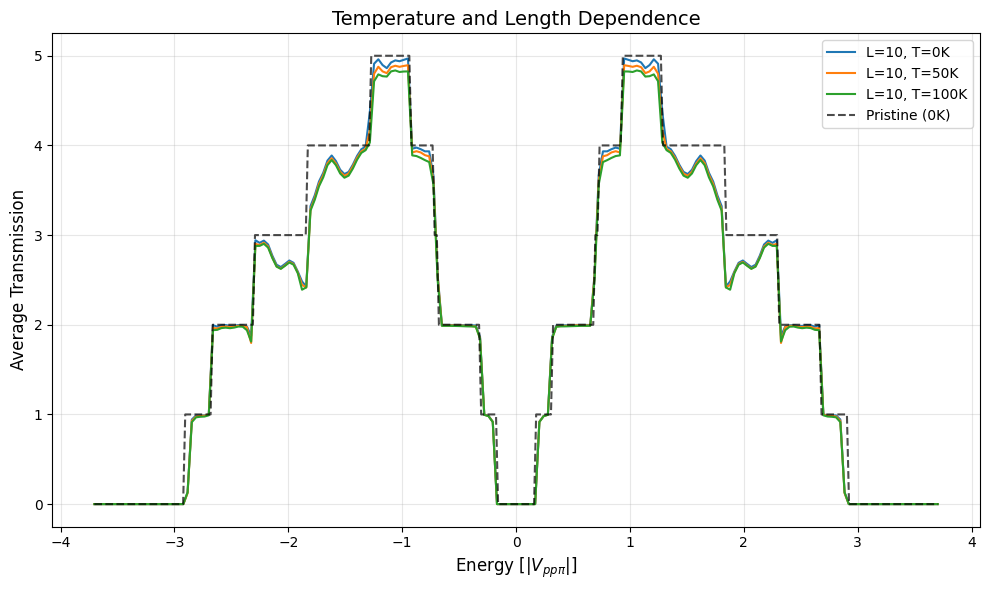

In [15]:
# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))

for (L, T_val), tr_data in results.items():
    ax.plot(energy_grid / 2.7, tr_data, label=f'L={L}, T={T_val}K', linewidth=1.5)

# Add 0K / Pristine transmission for comparison if available
if 'transmission' in locals():
    # Interpolate if grids differ or just plot
    # Assuming 'transmission' matches 'energy' (400 pts)
    ax.plot(energy_400 / 2.7, transmission, 'k--', label='Pristine (0K)', alpha=0.7)

ax.set_xlabel(r'Energy $[|V_{pp\pi}|]$', fontsize=12)
ax.set_ylabel('Average Transmission', fontsize=12)
ax.set_title('Temperature and Length Dependence', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()